## Develop approach to examine oxygen-percentiles

Following [Sohail et al. (2022)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020GL091439). **NOTE : need to check how to incorporate compressibility, i.e. use of *in situ* density.**

Ocean volume bounded by surfaces of tracer $\phi$:
$$\mathcal{V}(\phi^*,t) = \iiint_{\phi(x,y,z,t)>\phi^*}dxdydz$$
Tracer content/inventory ($\phi$) bounded by surface of tracer $\phi$:
$$\Phi(\phi^*,t) = \int_0^{\mathcal{V}(\phi^*,t)}\rho(x,y,z,t)\,\phi(x,y,z,t)d\mathcal{V}$$
Bounding tracer value of volume $\mathcal{V}$:
$$\mathcal{V}(\phi^*,t)\Leftrightarrow \phi^{\mathcal{V}}(\mathcal{V},t)$$
Tracer-percentile:
$$p(\phi^*,t) = 100*\mathcal{V}(\phi^*,t)/V_T$$
Tracer inventory as a function of tracer-percentile is:
$$\Phi(p,t) = 0.01V_T\int_0^p\rho(p,t)\phi^p(p,t)dp$$
where $\phi^p(p,t) \equiv \phi^{\mathcal{V}}(\mathcal{V},t)$ at $\mathcal{V}=0.01 \times p \times V_T$

In [1]:
import xarray as xr
import cftime
from xhistogram.xarray import histogram
import numpy as np
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

from tracerpercentile import *

### READ

In [2]:
dataset = 'gobai' # gobai, esm4, ...
if dataset=='gobai':
    rootdir = '/projects/SOCCOM/datasets/gobai-o2/'
    filename = 'GOBAI-O2-v1.0_processed.zarr'
    ds = xr.open_zarr(rootdir+filename)
    grid = xr.open_dataset(rootdir+'regular_grid.nc')
    ds['volcello']=grid['rC']*grid['dp']
    
    tracer = ds['oxy']
    volume = ds['volcello']
    tracer_bins = np.linspace(0,400,400)
    prefactor = 1035
    
elif dataset=='esm4':
    config_id = 'ESM4_historical_D1'
    ds_datadir = '/work/gam/projects/oxygen/data/'
    ds_filename = 'ds.'+config_id+'.zarr'
    ds = xr.open_zarr(ds_datadir+ds_filename)
    
    tracer = ds['o2']
    volume = ds['volcello']
    tracer_bins = np.linspace(0,0.4,400)
    prefactor = 1

### CALCULATE

In [3]:
percentiles = np.linspace(1,100,100)
tp,VT = calc_tracerpercentile(tracer = tracer,
                              volume = volume,
                              tracer_bins=tracer_bins,
                              percentiles=percentiles,
                              ascending=False,
                              verbose=True)
Tp = calc_extensive(tp,VT.mean('time'),prefactor=prefactor)

Computing volumetric histogram.
[########################################] | 100% Completed | 28.00 s
Inverting for tracer percentile at each time.
time index : 0/216
time index : 10/216
time index : 20/216
time index : 30/216
time index : 40/216
time index : 50/216
time index : 60/216
time index : 70/216
time index : 80/216
time index : 90/216
time index : 100/216
time index : 110/216
time index : 120/216
time index : 130/216
time index : 140/216
time index : 150/216
time index : 160/216
time index : 170/216
time index : 180/216
time index : 190/216
time index : 200/216
time index : 210/216


### SAVE

In [7]:
Tp.name = tp.name+'_extensive'
ds_tp = xr.merge([tp,Tp])
with ProgressBar():
    ds_tp.to_netcdf('../data/tracerpercentiles/oxygen.'+dataset+'.nc')

[########################################] | 100% Completed | 27.74 s


### PLOT

In [24]:
with ProgressBar():
    tp.load()
    Tp.load()

[########################################] | 100% Completed | 27.50 s


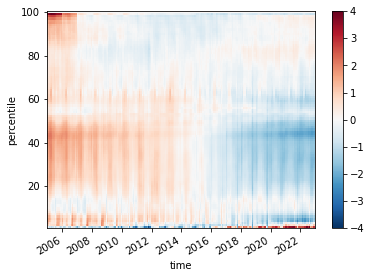

In [25]:
(tp-tp.mean('time')).plot()

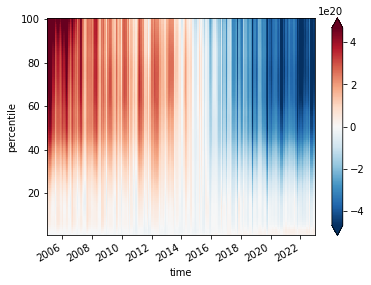

In [26]:
(Tp-Tp.mean('time')).plot(robust=True)

In [27]:
t1 = ['2005','2009']
t2 = ['2010','2014']
t1slice = slice(t1[0]+'-01-01',t1[1]+'-12-31')
t2slice = slice(t2[0]+'-01-01',t2[1]+'-12-31')
t1label = t1[0]+' to '+t1[1]
t2label = t2[0]+' to '+t2[1]
t1color='tab:blue'
t2color='tab:orange'
dt = cftime.datetime(int(t2[1]),12,31)-cftime.datetime(int(t1[1]),12,31)
dt = dt.days*24*60*60

In [28]:
tp_t1 = tp.sel(time=t1slice).mean('time')
tp_t2 = tp.sel(time=t2slice).mean('time')
Tp_t1 = Tp.sel(time=t1slice).mean('time')
Tp_t2 = Tp.sel(time=t2slice).mean('time')

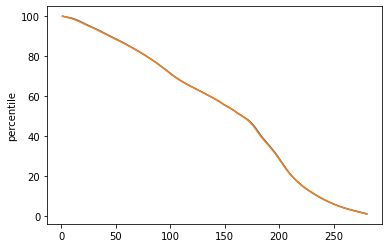

In [29]:
tp_t1.plot(y='percentile')
tp_t2.plot(y='percentile')

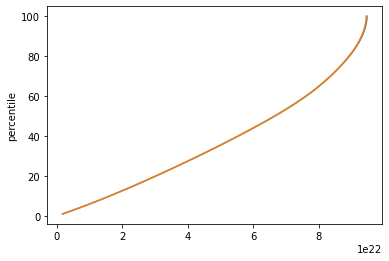

In [30]:
Tp_t1.plot(y='percentile')
Tp_t2.plot(y='percentile')

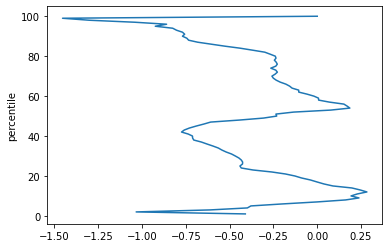

In [31]:
(tp_t2-tp_t1).plot(y='percentile')

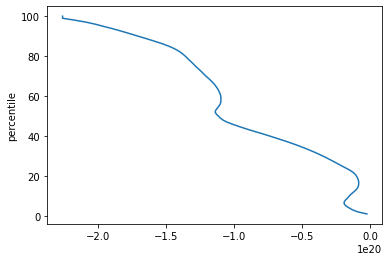

In [32]:
(Tp_t2-Tp_t1).plot(y='percentile')

In [16]:
tp.time

<xarray.DataArray 'time' (time: 216)>
array(['2005-01-14T00:00:00.000000000', '2005-02-14T00:00:00.000000000',
       '2005-03-15T00:00:00.000000000', ..., '2022-10-15T00:00:00.000000000',
       '2022-11-15T00:00:00.000000000', '2022-12-15T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-14 2005-02-14 ... 2022-12-15